## Using Python and SQLite to implement a gravity model based on Github user data

---
<br>

**This project was part of a lecture series on Machine Learning methods for Economic Research during my
master studies and was implemented under the guidance of my teachers.**

<br>

**Data**
* Part of the GitHub Database, originally from https://ghtorrent.org/downloads.html 
* Part of the CEPII Gravity dataset used to estimate trade gravity equations http://www.cepii.fr/cepii/en/bdd_modele/presentation.asp?id=8


<br>

The task is to estimate a gravity model (https://en.wikipedia.org/wiki/Gravity_model_of_trade). However, instead of trade flows we will look at the collaborations of programmers on GitHub. 

Some vocabulary: 
* User - registered user on the Github Platform (think of a programmer who uses Github for his/her software projects).
* Repository - is usually used to organize a single project. Repositories can contain folders and files, codes, images, videos, spreadsheets, and data sets – anything a project needs.
* Repository owner - a Github user who started a given repository (project). 
* Commit - any source code modification by a Github user. 

Our Github data includes: 
* Table 'Commits': includes all commits realized in October 2018 by a given user to a given repository. This table only has committer and repository IDs. 
* Table 'Users': information on users who had at least 1 commit in October 2018. This table, among other information, contains self-reported user location.
* Table 'Projects': information on repositories that had at least 1 commit in October 2018. This table contains the ID of the repository's owner, which can be linked back to the 'Users' table. 

How can we measure international collaborations on GitHub? 

One way that we will use here: define a collaboration international if a user from one country contributes to a repository (=project) owned by a user from another country. Our main outcome variable will be the number of contributions by commiters from one country to projects owned by users from another country. 

CEPII dataset contains necessary variables for estimating the gravity model (e.g. GDP, population, distance, common language, common border etc.).

**Using SQLite and SQL**
* We will upload commits, users, and projects tables in a sqlite3 database using Python
* Investigate the data with simple filtering and aggregation queries
* Use more complex queries to merge and aggregate the GitHub tables and prepare the dataset for the regression analysis

---


In [1]:
# import the necessary packages
import sys, time
import pandas as pd
import numpy as np
import sqlite3, csv


In [2]:
#create connection to database (SQLite)

conn = sqlite3.connect('github_DB.sqlite') #if there was no database with such name in your folder, a new one will be created 
cur = conn.cursor() #define cursor object to send commands to SQL
print("Connection established", cur)

Connection established <sqlite3.Cursor object at 0x0000023E6E274240>


In [3]:
# create tables for USERS, projects, and commits 
cur.executescript('''
DROP TABLE IF EXISTS users;
CREATE TABLE users (
  id INTEGER NOT NULL PRIMARY KEY ,
  login VARCHAR(255) DEFAULT NULL,
  created_at TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
  long DECIMAL(11,8)  DEFAULT NULL ,
  lat DECIMAL(10,8)  DEFAULT NULL ,
  country_code VARCHAR(255) DEFAULT NULL ,
  city VARCHAR(255) DEFAULT NULL)
''')
print("Table created")

Table created


In [4]:
#loading data from csv files into created tables

data = open('users.csv', 'rt', encoding="utf8", errors = "replace")  
dr = list(csv.reader(data))[1:] #comma is default delimiter

# command to insert a row of data in the table from the DB. '?' - wildcard, values change with each row
script = '''INSERT OR REPLACE INTO users (id, login, created_at, long, lat, country_code, city) 
VALUES (?, ?, ?, ?,?,?, ?)'''

cur.executemany(script, dr)
conn.commit() #save the changes to the database 
print("Table imported")


Table imported


In [5]:
# write a function to upload other datasets 
# Note: data - csv table to import; labels - column names; table - table name in our database. 
def import_table(data, labels, table, encode):
    values = (("?, ")*(labels.count(",")+1))[:-2]
    script = "INSERT OR REPLACE INTO " + table + " (" + labels + ") " + "VALUES (" + values + ")"
    with open(data, 'rt', encoding = encode, errors = "replace") as ins:
        dr = list(csv.reader(ins))[1:]
        cur.executemany(script, dr)
        conn.commit()
    return print("Table ", table, " imported")

In [6]:
# rewrite users table using the above function 
cur.executescript('''DELETE FROM users''') # drops all observations

In [7]:
data = "users.csv"
labels = "id, login, created_at, long, lat, country_code, city"
encode = "utf8"
table = "users"
import_table(data, labels, table, encode)

Table  users  imported


In [8]:
#first query
out = cur.execute('''
SELECT * FROM users LIMIT 5''')
cur.fetchall()

[(2,
  'jmettraux',
  '2008-03-22 00:37:42 UTC',
  132.4552927,
  34.3852029,
  'jp',
  'Hiroshima'),
 (5,
  'weppos',
  '2008-04-06 08:44:35 UTC',
  12.4963655,
  41.9027835,
  'it',
  'Rome'),
 (9,
  'ben-biddington',
  '2008-11-03 12:13:46 UTC',
  174.776236,
  -41.2864603,
  'nz',
  'Wellington'),
 (12, 'lbt', '2009-05-24 15:29:53 UTC', -3.435973, 55.378051, 'gb', ''),
 (14,
  'nanounanue',
  '2010-11-24 05:43:29 UTC',
  -87.6297982,
  41.8781136,
  'us',
  'Chicago')]

In [9]:
# Note that columns' names (heading of the table) is not stored in out! 
# It is stored separately in the first column of cur.description
for i in cur.description:
    print(i[0])

id
login
created_at
long
lat
country_code
city


In [10]:
# we can also use pandas to get a nicer view of the queries' results
out = cur.execute('''
SELECT * FROM users LIMIT 5''')
out = pd.DataFrame(list(out)) # put in a dataframe 
out.columns = [i[0] for i in cur.description] # column names are stored separately
out

,id,login,created_at,long,lat,country_code,city
0,2,jmettraux,2008-03-22 00:37:42 UTC,132.455293,34.385203,jp,Hiroshima
1,5,weppos,2008-04-06 08:44:35 UTC,12.496365,41.902783,it,Rome
2,9,ben-biddington,2008-11-03 12:13:46 UTC,174.776236,-41.286460,nz,Wellington
3,12,lbt,2009-05-24 15:29:53 UTC,-3.435973,55.378051,gb,
4,14,nanounanue,2010-11-24 05:43:29 UTC,-87.629798,41.878114,us,Chicago


In [11]:
# function represents the results of the query as a DataFrame
def view_query(script):
    out = pd.DataFrame(list(cur.execute(script))) # put in a dataframe 
    out.columns = [i[0] for i in cur.description] # column names are stored separately
    return out

In [12]:
# try out the function and obtain some basic summary statistics 
script = '''SELECT COUNT(*) as Number_Users, MIN(created_at) as Oldest_User, 
MAX(created_at) as Youngest_User FROM users'''
view_query(script)                                # alternate: use pd.read_sql()

,Number_Users,Oldest_User,Youngest_User
0,292380,2007-10-20 03:24:19 UTC,2019-04-22 17:44:51 UTC


In [13]:
# projects table
cur.executescript('''
DROP TABLE IF EXISTS projects;
CREATE TABLE projects (
  id INTEGER NOT NULL PRIMARY KEY,
  owner_id INTEGER DEFAULT NULL,
  name VARCHAR(255) DEFAULT NULL,
  language VARCHAR(255) DEFAULT NULL,
  created_at timestamp NOT NULL DEFAULT CURRENT_TIMESTAMP,
  forked_from INTEGER DEFAULT NULL,
FOREIGN KEY (owner_id) REFERENCES users (id), 
FOREIGN KEY (forked_from) REFERENCES projects (id)
) 
''')
data = "projects.csv"
labels = "id, owner_id, name, language, created_at, forked_from"
encode = "utf8"
table = "projects"
import_table(data, labels, table, encode)

#foreign keys - constraint, e.g. will not delete users table without relaxing the constraint with the key.

Table  projects  imported


In [14]:
# commits
cur.executescript('''
DROP TABLE IF EXISTS commits;
CREATE TABLE commits (
  commiter_id INTEGER NOT NULL,
  project_id INTEGER NOT NULL,
  year INTEGER NOT NULL,
  month INTEGER NOT NULL,
  num_commits INTEGER NOT NULL,
  FOREIGN KEY (project_id) REFERENCES projects (id),
  FOREIGN KEY (commiter_id) REFERENCES users (id))
''')
data = "commits.csv"
labels = "commiter_id, project_id, year, month, num_commits"
encode = "utf8"
table = "commits"
import_table(data, labels, table, encode)

Table  commits  imported


In [15]:
# run basic queries
script = '''
SELECT * FROM projects LIMIT 10'''
view_query(script)

,id,owner_id,name,language,created_at,forked_from
0,6,31,cocos2d-x,C++,2010-11-18 23:17:00 UTC,
1,11,69,heroku-buildpack-scala,Shell,2011-05-16 21:41:09 UTC,
2,19,78,NewsBlur,Objective-C,2009-01-05 14:00:43 UTC,
3,37,159,angular.js,JavaScript,2010-01-06 00:34:37 UTC,
4,63,394,unisubs,Python,2011-08-19 22:04:08 UTC,
5,71,672,llvm,LLVM,2012-01-27 23:49:56 UTC,
6,88,866,spring-integration,Java,2011-08-12 15:45:00 UTC,4952338
7,92,877,i18n-js,JavaScript,2009-09-02 03:35:45 UTC,
8,100,159,angular-seed,JavaScript,2010-12-24 06:07:50 UTC,
9,105,963,libuv,C,2015-01-23 22:47:25 UTC,6690806


In [16]:
script = '''
SELECT * FROM commits LIMIT 10'''
view_query(script)

,commiter_id,project_id,year,month,num_commits
0,48185673,130883963,2018,10,62
1,4595410,102153733,2018,10,96
2,2141459,12992548,2018,10,86
3,10447554,102219925,2018,10,39
4,43229289,132605637,2018,10,19
5,10145809,63990967,2018,10,184
6,2999692,80238834,2018,10,95
7,37761145,50020,2018,10,22
8,37172009,100524541,2018,10,38
9,10900061,70961872,2018,10,31


In [17]:
# Basic Queries continued
# Select users based in Belarus who joined GitHub on 15.10.2014 

script='''
SELECT *
FROM users
WHERE country_code = 'by' AND DATE(SUBSTR(created_at, 1 ,10)) = DATE('2014-10-15')
'''
 
view_query(script)

,id,login,created_at,long,lat,country_code,city
0,5761405,LeikoDmitry,2014-10-15 20:19:17 UTC,27.504299,53.883202,by,Minsk


In [18]:
script ='''
SELECT * 
FROM users
WHERE (country_code = "kp" OR country_code = "de") 
AND date(substr(created_at, 1, 10)) = date('2013-12-31')
                          
ORDER BY created_at
'''
view_query(script)

,id,login,created_at,long,lat,country_code,city
0,3154233,dajusc,2013-12-31 00:19:00 UTC,10.451526,51.165691,de,
1,4470705,Vnthf,2013-12-31 08:42:50 UTC,127.018770,38.714517,kp,
2,10601565,frickler24,2013-12-31 11:38:34 UTC,10.451526,51.165691,de,
3,3156306,phauer,2013-12-31 12:27:31 UTC,12.373075,51.339695,de,Leipzig


In [19]:
# Modify the above query to return users from DE or North Korea who registered on the GitHub on 2013-12-31. 

script ='''
SELECT * 
FROM users
WHERE country_code IN ("de","kp") 
AND date(substr(created_at, 1, 10)) = date('2013-12-31') 
ORDER BY created_at
'''
view_query(script)


,id,login,created_at,long,lat,country_code,city
0,3154233,dajusc,2013-12-31 00:19:00 UTC,10.451526,51.165691,de,
1,4470705,Vnthf,2013-12-31 08:42:50 UTC,127.018770,38.714517,kp,
2,10601565,frickler24,2013-12-31 11:38:34 UTC,10.451526,51.165691,de,
3,3156306,phauer,2013-12-31 12:27:31 UTC,12.373075,51.339695,de,Leipzig


In [20]:
script = '''
SELECT DISTINCT language 
FROM projects
WHERE language LIKE "SQ%" 
ORDER BY language ASC
'''
view_query(script)

,language
0,SQF
1,SQL
2,SQLPL
3,Squirrel


In [21]:
# Aggregation 

# Select top 10 countries on GitHUB by the number of registered users. What is your guess of the top 3? 
script = '''
SELECT COUNT(id) as number_users, country_code 
FROM users
GROUP BY country_code 
ORDER BY number_users DESC
LIMIT 10
'''
view_query(script)


,number_users,country_code
0,81294,us
1,20504,cn
2,16022,gb
3,15543,de
4,13856,in
5,11600,br
6,10402,fr
7,10319,ca
8,9354,ru
9,7098,jp


In [22]:
# What are the top 10 countries on GitHub by the number of users who registered in 2018. 
# Which operator(s) do you use? 

script = '''
SELECT COUNT(id) as number_users, country_code
FROM users
WHERE DATE(SUBSTR(created_at, 1 ,4)) = DATE('2018')
GROUP BY country_code 
ORDER BY number_users DESC
LIMIT 10
'''
view_query(script)


,number_users,country_code
0,884,us
1,287,in
2,220,cn
3,206,br
4,138,fr
5,137,gb
6,122,ru
7,118,de
8,108,ca
9,98,pl


In [23]:
# Which operator do you use? Which cities have at least 3000 registered GitHub users?

script = '''
SELECT COUNT(id) as number_users, city
FROM users
WHERE city <> ""
GROUP BY city 
HAVING number_users >= 3000 
ORDER BY number_users DESC

'''
view_query(script)

,number_users,city
0,6524,London
1,5491,New York
2,5231,San Francisco
3,4627,Beijing
4,3548,Shanghai
5,3488,Seattle
6,3487,Paris
7,3272,Tokyo


In [24]:
# Updating data in the tables / Altering tables / Temporary views

# Replace missing cities with NULL values in the users table. 
script = '''
UPDATE users
SET city = NULL
WHERE city = ""
'''
cur.execute(script)
conn.commit()

In [25]:
# What is the share of users with NULL city value? Note: COUNT(column_name) returns the count of non-NULL observations. 

script = '''
SELECT COUNT(*) AS Total_Number, COUNT(city) AS City_Not_N, 
1-Count(city)/COUNT(*) AS Share_Null
FROM users 
'''
view_query(script)

,Total_Number,City_Not_N,Share_Null
0,292380,212648,1


In [26]:
# because COUNT by default returns an integer. count(city)/count(∗) will return 0. 
# Hence, we correct previous script as,
script = '''
SELECT COUNT(*) AS Total_Number, COUNT(city) AS City_Not_N, 
1-Count(city)*1.0/COUNT(*) AS Share_Null
FROM users 
'''
view_query(script)

,Total_Number,City_Not_N,Share_Null
0,292380,212648,0.2727


In [27]:
# using advanced queries, subqueries
#Select top ten countries by the number of registered users on GitHub who own repositories in Python language. 
#Note: it is also possible to run this query using JOIN. 

script='''
SELECT country_code, COUNT(*) AS Number_users
FROM users 
WHERE id IN 
    (SELECT DISTINCT owner_id
     FROM projects
     WHERE language = 'Python')
    
GROUP BY country_code
ORDER BY Number_users DESC
LIMIT 10
'''
view_query(script)

,country_code,Number_users
0,us,8359
1,in,1842
2,de,1571
3,cn,1548
4,gb,1486
5,ca,1046
6,br,1022
7,fr,918
8,ru,746
9,jp,594


In [28]:
# try with join
script='''
SELECT country_code, COUNT(DISTINCT p.owner_id) AS Number_users
FROM users u
INNER JOIN projects p
ON u.id = p.owner_id 
WHERE language = 'Python'

GROUP BY country_code
ORDER BY Number_users DESC

LIMIT 10
'''
view_query(script)

,country_code,Number_users
0,us,8359
1,in,1842
2,de,1571
3,cn,1548
4,gb,1486
5,ca,1046
6,br,1022
7,fr,918
8,ru,746
9,jp,594


In [33]:
#  preparation of the GitHub dataset for the analysis. 
# create a view joining projects and users, to obtain the country_code of project owners. 

script = '''
CREATE VIEW view_projects
AS
SELECT p.id AS project_id, owner_id, u.country_code AS owner_country
FROM projects p
INNER JOIN users u
ON p.owner_id = u.id
'''
cur.execute(script)

In [34]:
script='''
SELECT * FROM view_projects
LIMIT 10
'''
view_query(script)
# note that two queries are run here: 1) view_projects; 2) outer SELECT 

,project_id,owner_id,owner_country
0,19,78,us
1,92,877,ca
2,105,963,nl
3,168,142,us
4,320,2100,it
5,334,2163,se
6,431,3816,us
7,448,3877,us
8,471,3969,il
9,564,4291,fr


In [40]:
# we create temporary table by merging projects and commits, temp table so we can save and use it later no need to run again

script='''
CREATE TEMPORARY TABLE projects_commits
AS
SELECT commiter_id, owner_country, SUM(num_commits) AS number_commits
FROM commits c
INNER JOIN view_projects p
ON c.project_id = p.project_id
WHERE c.commiter_id <> p.owner_id 
GROUP BY commiter_id, owner_country
'''
cur.execute(script)

In [41]:
script='''
SELECT * FROM projects_commits
LIMIT 10
'''
view_query(script)

,commiter_id,owner_country,number_commits
0,6,ar,6
1,6,at,8
2,6,au,102
3,6,bd,1
4,6,br,54
5,6,by,3
6,6,ca,187
7,6,ch,2
8,6,cn,311
9,6,co,5


In [42]:
# merge projects_commits to users table to find out the country code of commiter. 
# Again, aggregate the dataset on commiter_country and owner_country.

script='''
CREATE TEMPORARY TABLE u_p_c
AS
SELECT u.country_code AS commiter_country, owner_country, SUM(number_commits) AS number_commits
FROM projects_commits pc
INNER JOIN users u
ON pc.commiter_id = u.id
GROUP BY commiter_country, owner_country
'''
cur.execute(script)


In [61]:
script='''
SELECT * FROM u_p_c

'''
df = view_query(script)

In [62]:
df

,commiter_country,owner_country,number_commits
0,ae,de,4
1,ae,fr,59
2,ae,in,1
3,ae,ir,22
4,ae,sg,1
...,...,...,...
1438,za,ro,1
1439,za,ug,1
1440,za,us,93
1441,za,za,256


In [63]:
df['pair_label'] = df['commiter_country'] + df['owner_country']

In [64]:
df = df[['commiter_country','owner_country','pair_label','number_commits']]

In [70]:
github = df.sort_values(by = 'number_commits',ascending=False).reset_index(drop=True)

In [71]:
github

,commiter_country,owner_country,pair_label,number_commits
0,us,us,usus,20180
1,de,de,dede,4661
2,fr,fr,frfr,2417
3,de,us,deus,2296
4,in,in,inin,2190
...,...,...,...,...
1438,pt,cl,ptcl,1
1439,gb,ug,gbug,1
1440,fr,lu,frlu,1
1441,pt,th,ptth,1


In [50]:
# Alternate Solution with case 
"""script = '''
SELECT commiter_country, owner_country,
       CASE
            WHEN commiter_country<owner_country THEN commiter_country || owner_country
            ELSE
                owner_country || commiter_country
        END pair_label,
        number_commits
FROM u_p_c
ORDER BY number_commits DESC'''
github = view_query(script)"""

In [69]:
conn.close() #close the connection with the database

In [74]:
#preparing CEPII data
cepii = pd.read_csv("gravdata_cepii.csv")
cepii.head()

,iso2_o,iso2_d,contig,distw,pop_o,pop_d,gdp_o,gdp_d,tdiff,eu_o,eu_d,comlang
0,AD,AD,0,11.227382,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0
1,AE,AD,0,5239.465258,9.156963,NaN,3.702963e+11,NaN,3.0,0.0,0.0,0
2,AF,AD,0,5712.403090,32.526562,NaN,1.933129e+10,NaN,3.5,0.0,0.0,0
3,AG,AD,0,6574.278311,0.091818,NaN,1.259259e+09,NaN,5.0,0.0,0.0,0
4,AI,AD,0,6593.264971,NaN,NaN,NaN,NaN,5.0,0.0,0.0,0


In [75]:
# rename iso2_o and iso2_d to avoid confusion (but it is not necessary for merging)
cepii = cepii.rename(columns={"iso2_d" : "owner_country", "iso2_o": "commiter_country"})
#change subscripts _o and _c
cepii.columns = [x.replace("_o", "_commiter").replace("_d", "_owner") for x in cepii.columns]
cepii.head()

,commiter_country,owner_country,contig,distw,pop_commiter,pop_owner,gdp_commiter,gdp_owner,tdiff,eu_commiter,eu_owner,comlang
0,AD,AD,0,11.227382,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0
1,AE,AD,0,5239.465258,9.156963,NaN,3.702963e+11,NaN,3.0,0.0,0.0,0
2,AF,AD,0,5712.403090,32.526562,NaN,1.933129e+10,NaN,3.5,0.0,0.0,0
3,AG,AD,0,6574.278311,0.091818,NaN,1.259259e+09,NaN,5.0,0.0,0.0,0
4,AI,AD,0,6593.264971,NaN,NaN,NaN,NaN,5.0,0.0,0.0,0


In [76]:
#change country codes to lower case
for x in ["commiter_country", "owner_country"]:
    cepii[x] = cepii[x].str.lower() 

In [81]:
#merge with github data from SQL exercise
merged = pd.merge(github, cepii, on = ['commiter_country', 'owner_country'])
merged.head()

,commiter_country,owner_country,pair_label,number_commits,contig,distw,pop_commiter,pop_owner,gdp_commiter,gdp_owner,tdiff,eu_commiter,eu_owner,comlang
0,us,us,usus,20180,0,1853.802467,321.418823,321.418823,1.803665e+13,1.803665e+13,0.0,NaN,NaN,0
1,de,de,dede,4661,0,301.082594,81.413147,81.413147,3.363447e+12,3.363447e+12,0.0,NaN,NaN,0
2,fr,fr,frfr,2417,0,408.960309,66.808388,66.808388,2.418835e+12,2.418835e+12,0.0,NaN,NaN,0
3,de,us,deus,2296,0,7595.451783,81.413147,321.418823,3.363447e+12,1.803665e+13,8.5,1.0,0.0,0
4,in,in,inin,2190,0,868.567365,1311.050537,1311.050537,2.095398e+12,2.095398e+12,0.0,NaN,NaN,0


In [ ]:
# Implement gravity model
# run linear regression
# we log the variables

In [82]:
# transformations 
# create a copy of the dataset just in case
merged_T = merged.copy()
merged_T.head()

# drop internal commits, get the indices and drop them 
# the original CEPII coding of common language/borders is not correct for same-country pairs
indexN = merged_T[(merged_T['commiter_country'] == merged_T['owner_country'])].index
merged_T.drop(indexN, inplace = True)
merged_T.head()

,commiter_country,owner_country,pair_label,number_commits,contig,distw,pop_commiter,pop_owner,gdp_commiter,gdp_owner,tdiff,eu_commiter,eu_owner,comlang
3,de,us,deus,2296,0,7595.451783,81.413147,321.418823,3.363447e+12,1.803665e+13,8.500000,1.0,0.0,0
7,us,de,usde,1568,0,7595.451770,321.418823,81.413147,1.803665e+13,3.363447e+12,8.500000,0.0,1.0,0
10,fr,us,frus,1372,0,7456.767207,66.808388,321.418823,2.418835e+12,1.803665e+13,8.500000,1.0,0.0,0
12,ca,us,caus,1110,1,2079.296721,35.851772,321.418823,1.550537e+12,1.803665e+13,2.083334,0.0,0.0,1
15,es,us,esus,1035,0,7437.156982,46.418270,321.418823,1.199057e+12,1.803665e+13,8.000000,1.0,0.0,1


In [83]:
# log the variables 
for x in [[3]+list(range(5,10))]:
    merged_T.iloc[:, x] = np.log(merged_T.iloc[:,x]+1)
    

# alternatively: np.arcsinh() - now more widespread, as it is defined at zero. 
# Therefore, if your data has many zeros or observations close around zero it is a preferable transformation. 

In [84]:
# alternative: linear model from sklearn or run on stata, R
import statsmodels.api as sm
merged_T.describe()

,number_commits,contig,distw,pop_commiter,pop_owner,gdp_commiter,gdp_owner,tdiff,eu_commiter,eu_owner,comlang
count,1330.000000,1330.000000,1330.000000,1328.000000,1329.000000,1327.000000,1327.000000,1330.000000,1330.000000,1330.000000,1330.000000
mean,2.042503,0.063910,8.423022,3.651185,3.713857,27.245619,27.258337,4.472932,0.441353,0.390226,0.160902
std,1.373532,0.244684,0.994039,1.517556,1.560220,1.595874,1.585439,3.514354,0.496735,0.487984,0.367579
min,0.693147,0.000000,5.087154,0.053607,0.031286,20.707212,20.707212,0.000000,0.000000,0.000000,0.000000
25%,1.098612,0.000000,7.635861,2.383675,2.379442,26.207218,26.371195,1.000000,0.000000,0.000000,0.000000
50%,1.609438,0.000000,8.816338,3.663549,3.663549,27.091742,27.231722,4.500000,0.000000,0.000000,0.000000
75%,2.833213,0.000000,9.171891,4.411745,4.622021,28.370765,28.370765,7.350000,1.000000,1.000000,0.000000
max,7.739359,1.000000,9.880243,7.224185,7.224185,30.523427,30.523427,12.000000,1.000000,1.000000,1.000000


In [85]:
# set X and Y
X = merged_T.iloc[:, 4: ]
y = merged_T['number_commits']
X = sm.add_constant(X)

# do the estimation 
est = sm.OLS(y, X, missing='drop').fit()
est.summary()

# we see how distance has a -ve and significant effect on number of commits between countries, while country size and common
# language have a significant +ve effect. But data has some flaws and also Rsquared is not very high. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         number_commits   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     45.91
Date:                Tue, 18 Jan 2022   Prob (F-statistic):           1.15e-78
Time:                        00:42:08   Log-Likelihood:                -2100.0
No. Observations:                1324   AIC:                             4222.
Df Residuals:                    1313   BIC:                             4279.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -15.6979      1.387    -11.314      0.000     -18.420     -12.976
contig           0.0790      0.156      0.507      0.612      -0.227       0.385
distw           -0.2677      0.072     -3.743      0.000      -0.408      -0.127
pop_commiter    -0.0846      0.036     -2.361      0.018      -0.155      -0.014
pop_owner       -0.0320      0.035     -0.921      0.357      -0.100       0.036
gdp_commiter     0.3974      0.033     12.057      0.000       0.333       0.462
gdp_owner        0.3347      0.033     10.222      0.000       0.270       0.399
tdiff            0.0608      0.017      3.505      0.000       0.027       0.095
eu_commiter      0.3105      0.081      3.816      0.000       0.151       0.470
eu_owner         0.0694      0.084      0.823      0.411      -0.096       0.235
comlang          0.2065      0.096      2.151      0.032       0.018       0.395
==============================================================================
Omnibus:                       87.376   Durbin-Watson:                   0.497
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.812
Skew:                           0.682   Prob(JB):                     2.87e-23
Kurtosis:                       3.139   Cond. No.                     1.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
# we try to include commiter_country and owner_country fixed effects
dummies = [pd.get_dummies(merged_T[i], prefix=i, drop_first = True) for i in ['commiter_country', 'owner_country']]

In [88]:
# make sure to drop variables, which are fixed at origin and destination level (e.g. population and gdp in our data, as it is time-invariant)
X = merged_T.iloc[:, 4:6].join(merged_T.iloc[:, 10:]).join(dummies)

y = merged_T['number_commits']
X = sm.add_constant(X)

# do the estimation 
est = sm.OLS(y, X, missing='drop').fit()
est.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         number_commits   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     5.837
Date:                Tue, 18 Jan 2022   Prob (F-statistic):           4.52e-85
Time:                        01:08:34   Log-Likelihood:                -1824.8
No. Observations:                1330   AIC:                             4064.
Df Residuals:                    1123   BIC:                             5139.
Df Model:                         206                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.2675      0.917      1.382      0.167      -0.531       3.066
contig                  0.1216      0.149      0.817      0.414      -0.171       0.414
distw                  -0.1756      0.079     -2.224      0.026      -0.330      -0.021
tdiff                   0.0235      0.018      1.282      0.200      -0.012       0.059
eu_commiter             0.0807      0.468      0.172      0.863      -0.838       0.999
eu_owner                1.2395      0.459      2.701      0.007       0.339       2.140
comlang                 0.0166      0.111      0.150      0.881      -0.201       0.234
commiter_country_am    -1.2985      1.158     -1.121      0.262      -3.571       0.974
commiter_country_ar    -0.0804      0.575     -0.140      0.889      -1.208       1.048
commiter_country_at     0.3774      0.237      1.592      0.112      -0.088       0.842
commiter_country_au     0.9219      0.521      1.769      0.077      -0.101       1.944
commiter_country_bb     1.4211      1.164      1.220      0.223      -0.863       3.706
commiter_country_bd    -0.2698      0.734     -0.368      0.713      -1.709       1.170
commiter_country_be    -0.2335      0.222     -1.053      0.293      -0.669       0.202
commiter_country_bg    -0.7963      0.350     -2.276      0.023      -1.483      -0.110
commiter_country_bh    -2.8632      1.153     -2.484      0.013      -5.125      -0.601
commiter_country_bj    -0.6297      0.890     -0.708      0.479      -2.376       1.116
commiter_country_bo    -1.6454      1.159     -1.420      0.156      -3.919       0.628
commiter_country_br     0.6191      0.515      1.203      0.229      -0.391       1.629
commiter_country_by    -0.5099      0.608     -0.838      0.402      -1.704       0.684
commiter_country_ca     0.7044      0.510      1.380      0.168      -0.297       1.706
commiter_country_ch     0.6207      0.518      1.199      0.231      -0.395       1.637
commiter_country_cl    -0.4557      0.631     -0.723      0.470      -1.693       0.782
commiter_country_cm    -0.4903      0.790     -0.621      0.535      -2.040       1.059
commiter_country_cn     0.2364      0.517      0.458      0.647      -0.777       1.250
commiter_country_co    -0.4702      0.653     -0.720      0.471      -1.751       0.811
commiter_country_cr    -0.6077      0.676     -0.899      0.369      -1.934       0.719
commiter_country_cz    -0.1991      0.203     -0.981      0.327      -0.597       0.199
commiter_country_de     2.3981      0.147     16.318      0.000       2.110       2.687
commiter_country_dk     0.0387      0.223      0.174      0.862      -0.398       0.476
commiter_country_do    -0.4528      0.678     -0.668      0.504      -1.782       0.877
commiter_country_ec    -0.8648      0.909     -0.952      0.341      -2.647       0.918
com

<AxesSubplot:ylabel='Frequency'>

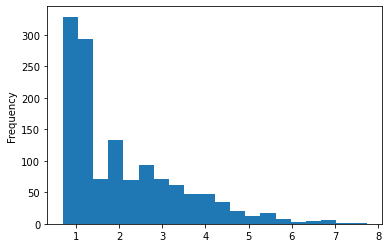

In [95]:
# distribution of logged number_commits
merged_T['number_commits'].plot.hist(bins=20)

In [ ]:
# by construction, we only have data for country pairs with at least one commit. Therefore, our results measure 
# the intensiveness of collaboration conditional on at least one bilateral contribution. We are ignoring all country pairs 
# with zero bilateral contributions. Once we add them, poisson or zero-inflated poisson model might be more appropriate for 
# our estimations. 